In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Define the simplified AlexNet model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6272, 1024),  # Adjusted to the correct size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model
model = SimplifiedAlexNet().to(device)

# Calculate the number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters:", params)

Number of parameters: 7012554


In [3]:
# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training settings
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")


Epoch 1, Training Loss: 1.4104247092438476, Validation Loss: 1.0884679079055786, Accuracy: 61.49%
Epoch 2, Training Loss: 1.079959673497378, Validation Loss: 0.962470144033432, Accuracy: 66.37%
Epoch 3, Training Loss: 0.9473424897626843, Validation Loss: 0.8280957341194153, Accuracy: 72.01%
Epoch 4, Training Loss: 0.8640868815848285, Validation Loss: 0.7717347025871277, Accuracy: 74.13%
Epoch 5, Training Loss: 0.8001313579204442, Validation Loss: 0.73965425491333, Accuracy: 74.72%
Epoch 6, Training Loss: 0.7556336848708369, Validation Loss: 0.7207825422286988, Accuracy: 75.74%
Epoch 7, Training Loss: 0.7092797228366213, Validation Loss: 0.7396604418754578, Accuracy: 74.68%
Epoch 8, Training Loss: 0.6779901274787191, Validation Loss: 0.6932560861110687, Accuracy: 76.31%
Epoch 9, Training Loss: 0.6474459592033835, Validation Loss: 0.6958972394466401, Accuracy: 75.85%
Epoch 10, Training Loss: 0.6231718707420028, Validation Loss: 0.6648525953292846, Accuracy: 77.54%
Epoch 11, Training Loss

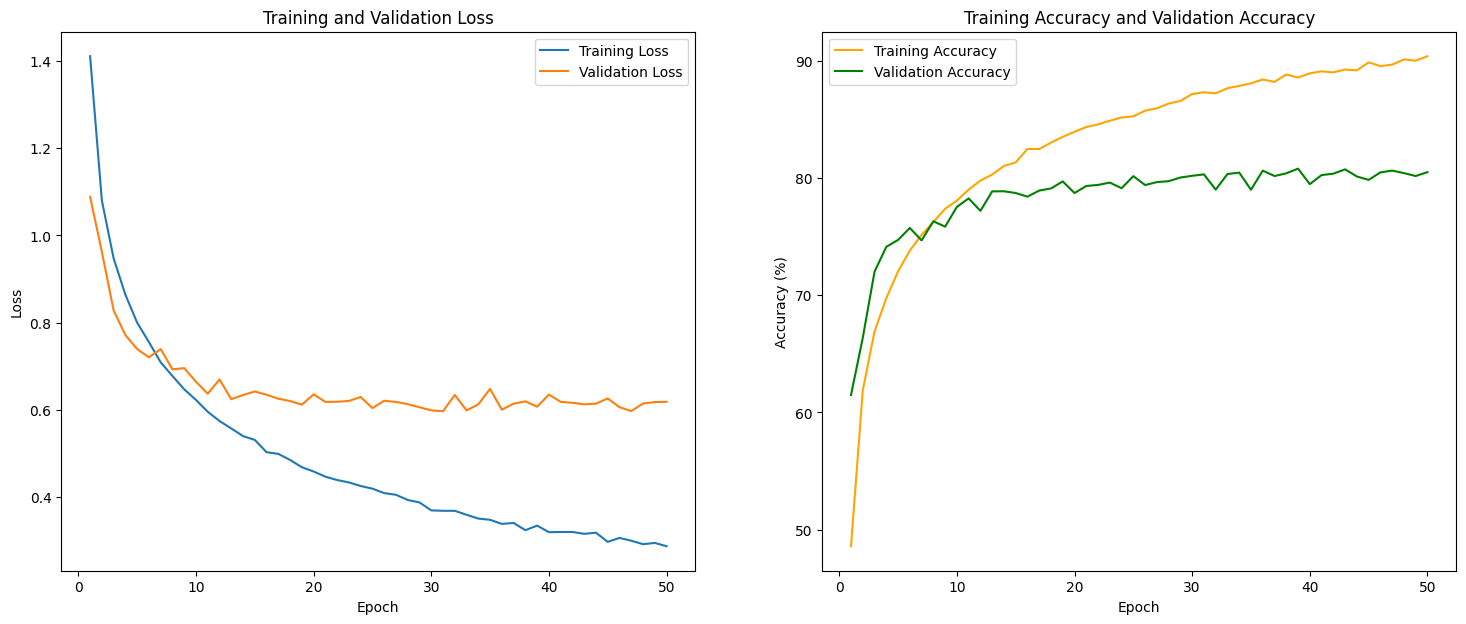

In [5]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [6]:
class AlexNetWithDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetWithDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),  # Dropout after max pooling
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),  # Dropout after max pooling
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout before fully connected layers
            nn.Linear(6272, 1024),  # Corrected to match the actual flattened size
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Additional dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
# Initialize the model
model1 = AlexNetWithDropout().to(device)

# Calculate the number of parameters
model1_parameters = filter(lambda p: p.requires_grad, model1.parameters())
params = sum([np.prod(p.size()) for p in model1_parameters])
print("Number of parameters:", params)

Number of parameters: 7012554


In [7]:
# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model1.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")

Epoch 1, Training Loss: 1.5747356273024284, Validation Loss: 1.3153024315834045, Accuracy: 53.95%
Epoch 2, Training Loss: 1.2961969963272515, Validation Loss: 1.1359457969665527, Accuracy: 62.65%
Epoch 3, Training Loss: 1.1820385027724458, Validation Loss: 1.0849005699157714, Accuracy: 63.8%
Epoch 4, Training Loss: 1.1078535966251208, Validation Loss: 1.0143359422683715, Accuracy: 66.85%
Epoch 5, Training Loss: 1.0602781277940707, Validation Loss: 0.9664016962051392, Accuracy: 69.9%
Epoch 6, Training Loss: 1.0247071735999163, Validation Loss: 0.944976133108139, Accuracy: 68.4%
Epoch 7, Training Loss: 1.0009192777869036, Validation Loss: 0.9062607765197754, Accuracy: 70.98%
Epoch 8, Training Loss: 0.9742060566649717, Validation Loss: 0.8691519141197205, Accuracy: 71.39%
Epoch 9, Training Loss: 0.9593045885300697, Validation Loss: 0.8725567579269409, Accuracy: 71.12%
Epoch 10, Training Loss: 0.9397544232018463, Validation Loss: 0.8711449563503265, Accuracy: 72.19%
Epoch 11, Training Loss

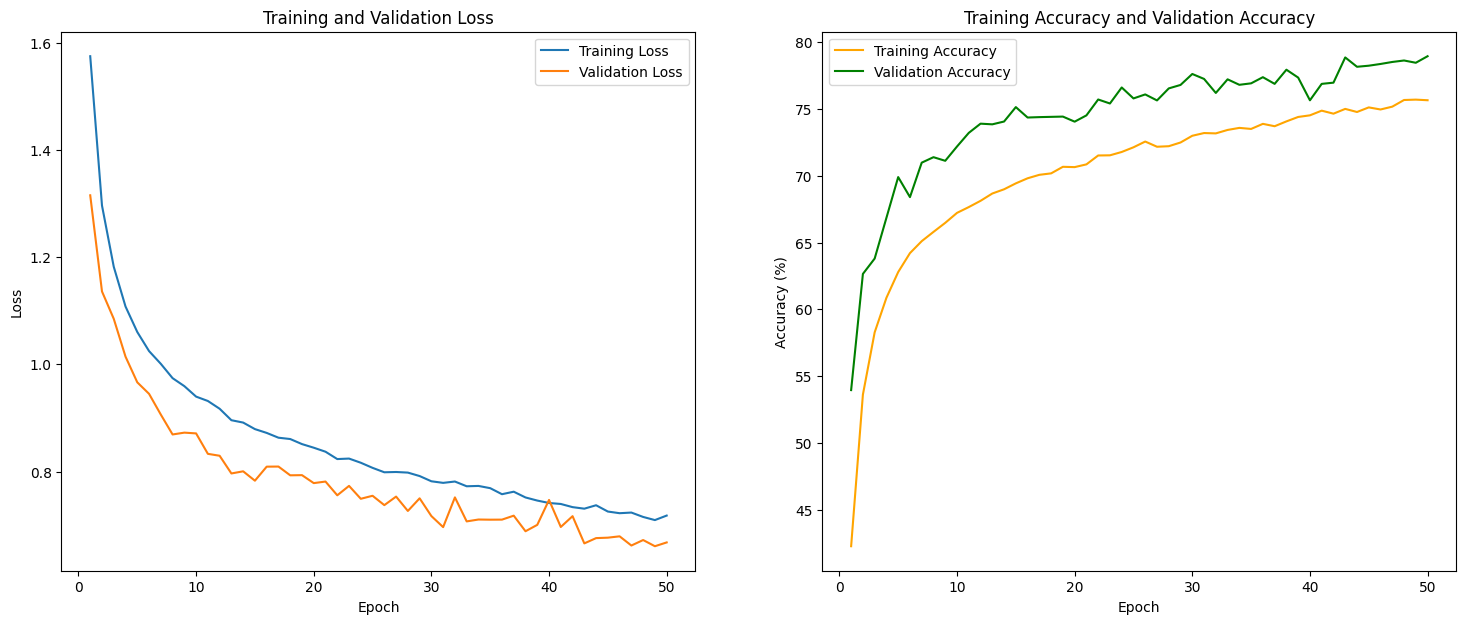

In [9]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [28]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the ResNet-18 model
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
# Count the number of trainable parameters
num_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print('Number of parameters in ResNet-18:', num_params)

Number of parameters in ResNet-18: 11181642


In [29]:
""# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    resnet18.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    resnet18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")

Epoch 1, Training Loss: 1.4012618364428011, Validation Loss: 1.1372611403465271, Accuracy: 59.68%
Epoch 2, Training Loss: 0.9878712015993455, Validation Loss: 0.9437865972518921, Accuracy: 66.69%
Epoch 3, Training Loss: 0.8076810787629594, Validation Loss: 0.851511687040329, Accuracy: 70.8%
Epoch 4, Training Loss: 0.6898800983758229, Validation Loss: 0.7515799343585968, Accuracy: 74.35%
Epoch 5, Training Loss: 0.5858211549346709, Validation Loss: 0.755314302444458, Accuracy: 74.37%
Epoch 6, Training Loss: 0.49898440775740177, Validation Loss: 0.7436249494552613, Accuracy: 74.92%
Epoch 7, Training Loss: 0.4183083239685544, Validation Loss: 0.7066960334777832, Accuracy: 77.7%
Epoch 8, Training Loss: 0.3384013425015732, Validation Loss: 0.7520841896533966, Accuracy: 77.27%
Epoch 9, Training Loss: 0.2707077174083046, Validation Loss: 0.7904229760169983, Accuracy: 76.7%
Epoch 10, Training Loss: 0.22031754703568224, Validation Loss: 0.8488179206848144, Accuracy: 76.98%
Epoch 11, Training Los

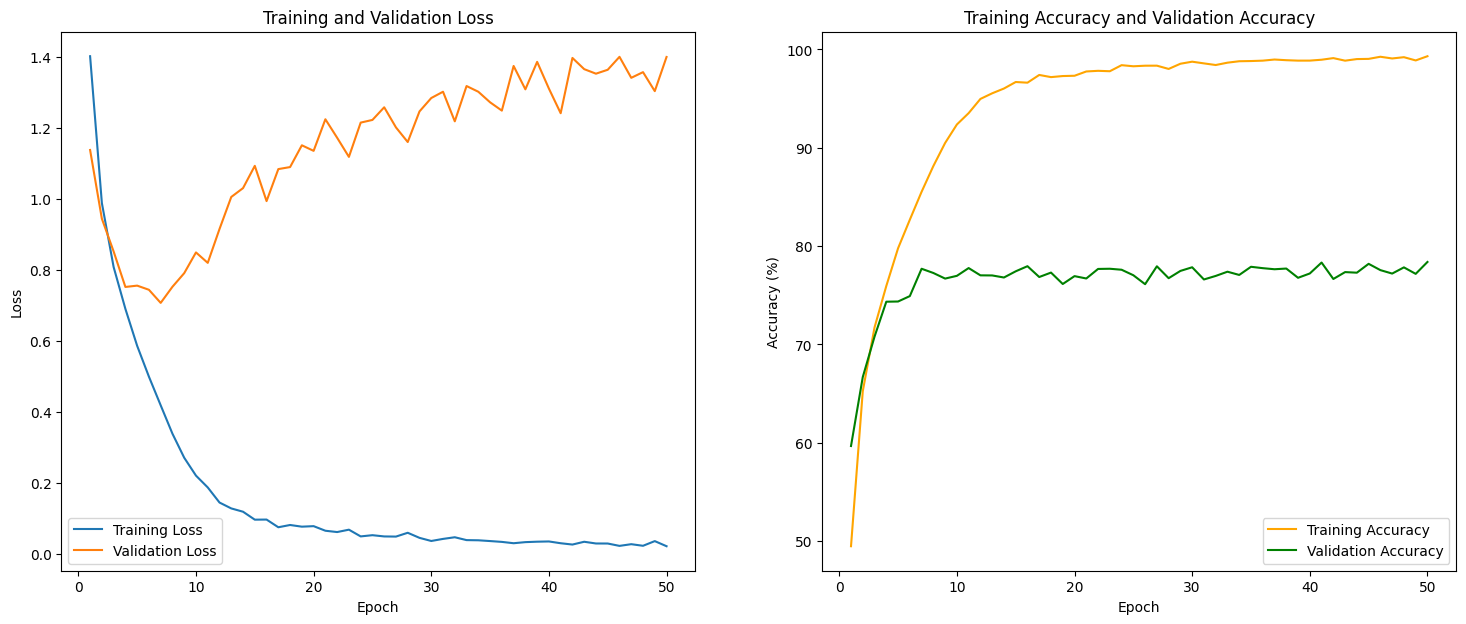

In [31]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [27]:
class BasicBlockWithDropout(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_rate=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_rate)  # First dropout layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)  # Second dropout layer
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)  # Apply first dropout

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)  # Apply second dropout

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
model2 = ResNet(BasicBlockWithDropout, [2, 2, 2, 2], dropout_rate=0.5).to(device)
    
# Count the number of trainable parameters
num_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print('Number of parameters in ResNet-18 with dropout:', num_params)

TypeError: ResNet.__init__() got an unexpected keyword argument 'dropout_rate'

In [15]:
""# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model2.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")

Epoch 1, Training Loss: 2.593181766817332, Validation Loss: 2.3713382482528687, Accuracy: 9.34%
Epoch 2, Training Loss: 2.595993774321378, Validation Loss: 2.370901870727539, Accuracy: 9.28%
Epoch 3, Training Loss: 2.596792568331179, Validation Loss: 2.369744157791138, Accuracy: 9.18%
Epoch 4, Training Loss: 2.5912465415037502, Validation Loss: 2.370592975616455, Accuracy: 9.36%
Epoch 5, Training Loss: 2.591266948548729, Validation Loss: 2.369730281829834, Accuracy: 9.08%
Epoch 6, Training Loss: 2.591522239358224, Validation Loss: 2.374078369140625, Accuracy: 9.05%
Epoch 7, Training Loss: 2.5876033071361846, Validation Loss: 2.368132400512695, Accuracy: 9.2%
Epoch 8, Training Loss: 2.585810787842402, Validation Loss: 2.3723428726196287, Accuracy: 9.25%
Epoch 9, Training Loss: 2.597387994036955, Validation Loss: 2.371956443786621, Accuracy: 9.06%
Epoch 10, Training Loss: 2.593494904010802, Validation Loss: 2.3671649932861327, Accuracy: 9.39%


In [ ]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()